<a href="https://colab.research.google.com/github/DmitryIo/animefaces/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/banana projects/anime-faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/banana projects/anime')

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/data/'
train_dir = '/content/drive/My Drive/banana projects/anime/data'
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   validation_split = 0.3,
                                   data_format='channels_last'
                                  )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   class_mode='input',
                                                   batch_size = 20,
                                                   target_size = (64, 64))
 

Found 21551 images belonging to 1 classes.


In [0]:
len(next(train_generator))

2

In [0]:
from matplotlib.pyplot import imshow

In [0]:
train_generator[0][1]

In [0]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
from keras.layers import Reshape
def create_deep_conv_ae():
    input_img = Input(shape=(64, 64, 3))

    x = Conv2D(512, (8, 8), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (8, 8), activation='relu', padding='same')(x)
    vector = Flatten()(encoded)
    vector = Dense(256, activation='relu')(vector)
    to_dec = Reshape((16,16,1))(vector)
    # vector.reshape(7,7,1)
    
    input_encoded = Input(shape=(16,16, 1))
    
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(x)
    
    encoder = Model(input_img, to_dec, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [0]:
!pip install tensorflow==1.14.0

In [3]:
encoder, decoder, autoencoder = create_deep_conv_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
autoencoder.fit(train_generator,
                epochs=100,
                shuffle=True)

In [4]:
autoencoder.load_weights("/content/model.h5")

In [0]:
weights_encoder = autoencoder.layers[1].get_weights()

In [0]:
encoder.set_weights(weights_encoder)

In [0]:

img = train_generator[0][0][0]
import tensorflow.keras.backend as K
img = img.reshape(1, 64, 64, 3)
img = K.constant(img)
# import matplotlib.pyplot as plt
# plt.imshow(img)

<tf.Tensor 'encoder_2/reshape_1/Reshape:0' shape=(1, 16, 16, 1) dtype=float32>

In [0]:
from keras import backend as K
sess = K.get_session()
encoder(img).eval(session=sess).shape

(1, 16, 16, 1)

In [0]:
import glob
import tensorflow.keras.backend as K
from keras import backend as L
import matplotlib.pyplot as plt
import cv2
train = []
count = 0
for filepath in glob.iglob('/content/drive/My Drive/banana projects/anime/data/*.png'):
    count+=1
    img = cv2.imread(filepath)
    img = img.reshape(1, 64, 64, 3)
    # img = K.constant(img)
    # sess = L.get_session()
    vector = encoder.predict(img) #.eval(session=sess)
    train.append(vector)
    if count >= 1000:
      break
    # break

In [22]:
import pandas as pd
indexes= ['str_' + str(i) for i in range(len(train))]
columnes = ['col_' + str(i) for i in range(len(train))]
# data = pd.DataFrame(index=)
data = pd.DataFrame(index=indexes, columns=columnes)
# data
# indexes
data


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,...,col_960,col_961,col_962,col_963,col_964,col_965,col_966,col_967,col_968,col_969,col_970,col_971,col_972,col_973,col_974,col_975,col_976,col_977,col_978,col_979,col_980,col_981,col_982,col_983,col_984,col_985,col_986,col_987,col_988,col_989,col_990,col_991,col_992,col_993,col_994,col_995,col_996,col_997,col_998,col_999
str_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
str_995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
str_998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train[0].reshape(16,16,1)

In [43]:

# cos(train[0].reshape(16,16), train[1].reshape(16,16)).shape
import numpy as np
def cos_sim(v1, v2):
  return v1 @ v2 /( np.linalg.norm(v1) * np.linalg.norm(v2))
cos_sim(train[0].reshape(256,), train[10].reshape(256,))

0.8599742

In [0]:
similarity = []
for i in range(len(train)):
  for j in range(len(train)):
    similarity.append(cos_sim(train[i].reshape(256,), train[j].reshape(256,)))
  data['col_'+str(i)] = similarity
  similarity = []
data.columns = ['img_' + str(i) for i in range(len(train))]
data.index =  ['img_' + str(i) for i in range(len(train))]

In [48]:
data

,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,img_10,img_11,img_12,img_13,img_14,img_15,img_16,img_17,img_18,img_19,img_20,img_21,img_22,img_23,img_24,img_25,img_26,img_27,img_28,img_29,img_30,img_31,img_32,img_33,img_34,img_35,img_36,img_37,img_38,img_39,...,img_960,img_961,img_962,img_963,img_964,img_965,img_966,img_967,img_968,img_969,img_970,img_971,img_972,img_973,img_974,img_975,img_976,img_977,img_978,img_979,img_980,img_981,img_982,img_983,img_984,img_985,img_986,img_987,img_988,img_989,img_990,img_991,img_992,img_993,img_994,img_995,img_996,img_997,img_998,img_999
img_0,1.000000,0.832752,0.831673,0.892819,0.903127,0.905349,0.790823,0.894270,0.909049,0.824141,0.859974,0.883697,0.876150,0.937423,0.893117,0.883158,0.894415,0.908569,0.889019,0.876106,0.867142,0.893600,0.869961,0.838887,0.900770,0.920831,0.901630,0.878535,0.838412,0.864063,0.864479,0.871082,0.850347,0.913084,0.882783,0.891134,0.885109,0.870334,0.861073,0.895501,...,0.901306,0.895565,0.892688,0.872884,0.861228,0.896234,0.881957,0.922781,0.874541,0.918624,0.852574,0.922781,0.874541,0.918624,0.852574,0.875397,0.916991,0.803429,0.856747,0.823542,0.882912,0.925605,0.932712,0.873067,0.913895,0.816209,0.895168,0.918258,0.894248,0.858751,0.906488,0.898434,0.901040,0.839048,0.860232,0.866600,0.888555,0.906053,0.913411,0.896207
img_1,0.832752,1.000000,0.786454,0.802873,0.836347,0.845114,0.771731,0.816822,0.855892,0.808858,0.781609,0.860093,0.761516,0.828720,0.799743,0.817221,0.801635,0.835568,0.867581,0.853162,0.841720,0.815886,0.866297,0.850401,0.830640,0.864046,0.810499,0.823833,0.795550,0.790063,0.736780,0.839414,0.734897,0.857622,0.809836,0.867661,0.823681,0.782827,0.869886,0.748648,...,0.835348,0.828145,0.837427,0.835981,0.810550,0.848893,0.876959,0.816838,0.809295,0.856882,0.833807,0.816838,0.809295,0.856882,0.833807,0.865875,0.814902,0.784382,0.732226,0.758782,0.829743,0.854371,0.794550,0.856680,0.862763,0.782968,0.789365,0.804203,0.858384,0.797161,0.881037,0.818191,0.798455,0.830719,0.850439,0.823789,0.867882,0.844893,0.848347,0.848840
img_2,0.831673,0.786454,1.000000,0.883452,0.868774,0.783442,0.823452,0.823447,0.842370,0.823736,0.831305,0.773670,0.788000,0.857814,0.816911,0.833710,0.829939,0.817686,0.822008,0.843414,0.777111,0.820507,0.817489,0.765865,0.866356,0.876180,0.812178,0.866800,0.886721,0.799965,0.779165,0.779294,0.787443,0.825054,0.861974,0.835662,0.836486,0.871480,0.775920,0.824381,...,0.799318,0.815444,0.800334,0.841674,0.890897,0.836660,0.831107,0.795187,0.845393,0.833884,0.852289,0.795187,0.845393,0.833884,0.852289,0.836675,0.859740,0.806176,0.848162,0.814807,0.809113,0.828401,0.828421,0.798690,0.802571,0.852824,0.784470,0.817573,0.811974,0.853689,0.826996,0.876845,0.856652,0.781875,0.789390,0.817762,0.779464,0.783944,0.820996,0.815757
img_3,0.892819,0.802873,0.883452,1.000000,0.916294,0.889772,0.805294,0.893905,0.882191,0.803097,0.879449,0.877162,0.860707,0.914845,0.884004,0.902889,0.895891,0.878445,0.852006,0.903106,0.856646,0.867308,0.847365,0.802310,0.882029,0.922212,0.893507,0.905114,0.858167,0.834314,0.857657,0.796232,0.795147,0.914553,0.893286,0.843235,0.858237,0.913113,0.821426,0.899063,...,0.872629,0.889463,0.881923,0.851195,0.862011,0.874354,0.871734,0.896084,0.893005,0.863239,0.885695,0.896084,0.893005,0.863239,0.885695,0.875377,0.901243,0.761150,0.803084,0.814657,0.879657,0.880257,0.893712,0.854561,0.869054,0.826978,0.835738,0.922697,0.878246,0.891789,0.885104,0.901454,0.889889,0.804183,0.845834,0.866062,0.866056,0.871000,0.899951,0.879669
img_4,0.903127,0.836347,0.868774,0.916294,1.000000,0.898952,0.831652,0.909127,0.925761,0.866249,0.882589,0.895626,0.906639,0.917437,0.912994,0.908668,0.920232,0.923904,0.910013,0.947594,0.886345,0.929674,0.888538,0.865630,0.919249,0.929227,0.913892,0.895117,0.822220,0.855501,0.873157,0.835798,0.827512,0.905896,0.896096,0.821146,0.888306,0.870966,0.897021,0.869748,...,0.890981,0.889288,0.889892,0.881232,0.899974,0.902450,0.906029,0.912539,0.899285,0.879632,0.912242,0.912539,0.89928

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
DIR = '/content/drive/My Drive/banana projects/anime/data/'
def similarities( number, data=data, the_most_similar=True):
  sort = data['img_' + str(number)].sort_values(ascending=False)[1:10]
  # for i in range(len(sort)):
    # if sort.index[i] == 'img_'+str(number):
      # sort[i] = 0
  
  # print(sort.index)
  if the_most_similar:
    plt.imshow(plt.imread(DIR + str(int(sort.index[0].replace('img_', ''))) + '.png'))


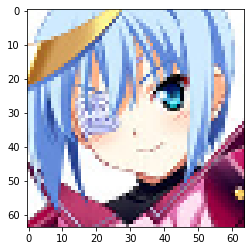

In [184]:
similarities(10)

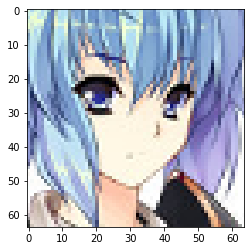

In [185]:
plt.imshow(plt.imread('/content/drive/My Drive/banana projects/anime/data/10.png'))

ё# New Section